In [1]:
# -*- coding: utf-8 -*-

"Contains functions to perform dynamic FBA."

from __future__ import absolute_import

from optlang.symbolics import Zero

from scipy.integrate import solve_ivp
import pandas as pd

def dynamic_fba(model_and_rxns, kinetic_eq):
    """
    Perform dynamic FBA to simulate batch growth of an organism.
    
    Dynamic FBA finds application in industrial fermentation process
    and modeling community growth of microorganisms, among others. It
    is an important tool which enhances FBA by adding reaction and
    metabolite dynamics. It can be be performed using mainly 3
    techniques: (1) Static Optimization Approach (SOA), 
    (2) Dynamic Optimization Approach, and (3) Direct Approach.
    This algorithm uses the Direct Approach which circumvents the
    inaccuracy of SOA and the Non-Linear Programming (NLP) complexity
    found in DOA. This approach employs Lexicographic Linear Programming
    to provide unique flux distribution and also solves the LP
    feasibility problem when integrating in DAE.
    
    Parameters
    ----------
    model_and_rxns: dict(model: cobra.Model, biomass: cobra.Reaction.id,
                         exchanges: tuple(cobra.Reaction.id))
        The model(s) to perform dynamic FBA on and the metabolites to track.
    kinetic_eq: scipy
    
    Returns
    -------

        
    References
    ----------
    .. [1] Gomez et al.: DFBAlab: a fast and reliable MATLAB code for dynamic flux balance analysis.
           BMC Bioinformatics 2014 15:409.
    """
    model = model_and_rxns["model"]
    biomass_rxn_id = model_and_rxns["biomass"]
    exchanges_rxn_id = model_and_rxns["exchanges"]
    rxn_list = [biomass_rxn_id]
    rxn_list.append(exchanges_rxn_id)
    # 1. LLP
    y = lexicographic_lp(model, rxn_list)
    # 2. ODE integration
    # a. modify "y" so that if fits into the kinetic equation
    # of the form "kinetic_eq(t, y)"
    # b. set y0 to the initial concentrations of the metabolites
    solution = solve_ivp(kinetic_eq, t_span, y0, method='LSODA')
    return solution

def lexicographic_lp(model, rxn_list):
    """
    Perform Lexicographic Linear Programming.
    
    Parameters
    ----------
    model: cobra.Model
        The model to perform lexicographic LP on.
    rxn_list: list(cobra.Reaction.id, tuple(cobra.Reaction.id)
        The list containing the reactions to be considered as objectives.
        
    Returns
    -------
    pandas.Series
    """
    biomass_rxn_id, ex_rxn_ids = rxn_list
    
    with model:
        # LP feasibility
        obj_vars = []
        for met in model.metabolites:
            s = model.problem.Variable("s_" + met.id, lb=0)
            beta = model.problem.Variable("beta_" + met.id, lb=0)
            s_equal_beta_const = model.problem.Constraint(
                s - beta,
                name="s_equal_beta_" + met.id, ub=0.0, lb=0.0)
            model.add_cons_vars([s, beta, s_equal_beta_const])
            model.constraints[met.id].set_linear_coefficients({s: 1.0, beta: -1.0})
            obj_vars.append(s)
        model.objective = model.problem.Objective(Zero, sloppy=True, direction="min")
        model.objective.set_linear_coefficients({v: 1.0 for v in obj_vars})
        model.objective_direction = "min"
        sol_feasibility = model.slim_optimize()
        feasibility_constraint = model.problem.Constraint(
            model.objective.expression,
            name="fixed_feasibility", ub=sol_feasibility, lb=sol_feasibility)
        model.add_cons_vars([feasibility_constraint])
        
        # Biomass
        model.objective = model.reactions.get_by_id(biomass_rxn_id)
        model.objective_direction = "max"
        sol_biomass = model.slim_optimize()
        biomass_constraint = model.problem.Constraint(
            model.objective.expression,
            name="fixed_biomass", ub=sol_biomass, lb=sol_biomass)
        model.add_cons_vars([biomass_constraint])
        
        # Exchanges
        for rxn_id in ex_rxn_ids:
            model.objective = model.reactions.get_by_id(rxn_id)
            model.objective_direction = "min"
            sol = model.slim_optimize()
            exchange_constraint = model.problem.Constraint(
                model.objective.expression,
                name="fixed_" + rxn_id, ub=sol, lb=sol)
            model.add_cons_vars([exchange_constraint])

        # Indexing list
        loc_list = [biomass_rxn_id]
        loc_list.extend(list(ex_rxn_ids))
        
        sol =  model.optimize()
        return pd.Series(sol.fluxes.loc[loc_list])

In [2]:
import cobra.test

In [3]:
%matplotlib inline

In [4]:
model = cobra.test.create_test_model('textbook')

In [5]:
lp = lexicographic_lp(model, ['Biomass_Ecoli_core', ('EX_glc__D_e', 'EX_co2_e')])

In [6]:
lp

Biomass_Ecoli_core     0.873922
EX_glc__D_e          -10.000000
EX_co2_e              22.809833
Name: fluxes, dtype: float64

In [7]:
def dummy_kin_eq(t, y):
    return y / (y + 1E-4)

In [8]:
sol = solve_ivp(dummy_kin_eq, [0, 100], lp, t_eval=[0, 2, 17, 28, 35, 47, 51, 64, 79, 86, 99], method='LSODA')

In [9]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 15
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  2, 17, 28, 35, 47, 51, 64, 79, 86, 99])
 t_events: None
        y: array([[  0.87392151,   2.87386883,  17.87376774,  28.87374011,
         35.87372253,  47.87370147,  51.87369594,  64.87367794,
         79.87366018,  86.87365324,  99.87364035],
       [-10.        ,  -7.99997044,   7.00010635,  18.00006834,
         25.00004416,  37.0000174 ,  41.00001088,  53.99998969,
         68.99996921,  75.99996144,  88.99994699],
       [ 22.80983331,  24.80982562,  39.80979267,  50.80977486,
         57.80976352,  69.80974858,  73.80974433,  86.80973052,
        101.80971649, 108.80971079, 121.8097002 ]])

In [10]:
df = pd.DataFrame(sol.y.transpose(), index=sol.t, columns=tuple(['Biomass_Ecoli_core', 'EX_glc__D_e', 'EX_co2_e']))

In [11]:
df

,Biomass_Ecoli_core,EX_glc__D_e,EX_co2_e
0,0.873922,-10.000000,22.809833
2,2.873869,-7.999970,24.809826
17,17.873768,7.000106,39.809793
28,28.873740,18.000068,50.809775
35,35.873723,25.000044,57.809764
47,47.873701,37.000017,69.809749
51,51.873696,41.000011,73.809744
64,64.873678,53.999990,86.809731
79,79.873660,68.999969,101.809716
86,86.873653,75.999961,108.809711


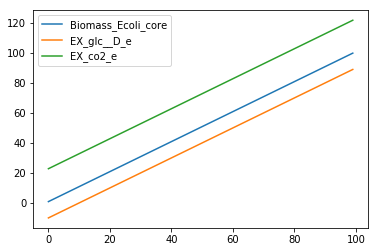

In [12]:
df.plot()